In [9]:
import jax
import jax.numpy as jnp
from jax import jit, random
import numpy as np
import optax

BATCH_SIZE = 100
LEARNING_RATE = 1e-3
LAYER_SIZES = [1, 25, 50, 30, 1]
NUM_TRAIN_STEPS = 1_000
NUM_EPOCHS = 3_000
#OPTIMIZER = optax.adam(learning_rate=LEARNING_RATE)
#OPTIMIZER = optax.yogi(learning_rate=LEARNING_RATE)
#OPTIMIZER = optax.adabelief(learning_rate=LEARNING_RATE)
#OPTIMZER = optax.fromage
OPTIMIZER = optax.optimistic_gradient_descent(learning_rate=LEARNING_RATE)
ACTIVATION = jnp.tanh
#ACTIVATION = jax.nn.relu
#ACTIVATION = jax.nn.sigmoid
#ACTIVATION = jax.nn.silu
#ACTIVATION = jax.nn.softplus
#ACTIVATION = jax.nn.softmax

t = jnp.linspace(start=0, stop=20, num=1000)

- See [Activation Functions](https://jax.readthedocs.io/en/latest/jax.nn.html?highlight=sigmoid) for a list of possible activations.
- See [Optimizers](https://optax.readthedocs.io/en/latest/api.html#optax.yogi) for a list of optimizers.

In [10]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,1))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  """
  returns:
  <list> of length: (#layers - 1)

  Each list item contains a <tuple> of len(): 2 (Weights and Biases)

  Each tuple consists of 2 Arrays of dimension: 

  """
  
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

initial_params = init_network_params(LAYER_SIZES, random.PRNGKey(0))

In [11]:
def net(params, x):
    activations = x
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = ACTIVATION(outputs)

    final_w, final_b = params[-1]
    output = jnp.dot(final_w, activations) + final_b
    return output.reshape()

# check
net(initial_params, 2.0)

Array(0.02171926, dtype=float32)

In [12]:
m = 1.
c = 0.1
k = 1.
y0 = 1.
y0_prime = 0.

@jit
def ode(params, t):
    nn = lambda t: net(params, t)
    dnn = jax.grad(nn)
    ddnn = jax.grad(dnn)
    return m * ddnn(t) + c * dnn(t) + k * nn(t)

# check
ode(initial_params, 3.0)

Array(0.02171909, dtype=float32)

In [13]:
ode_batched = jax.vmap(ode, in_axes=[None, 0])
dnn = jit(jax.grad(net, argnums=1))

@jit
def loss(params: optax.Params, batch: jnp.ndarray) -> jnp.ndarray:
    y_hat = ode_batched(params, batch)
    ode_loss = jnp.mean(y_hat ** 2)
    init_loss_1 = (net(params, 0.) - y0) ** 2
    init_loss_2 = (dnn(params, 0.) - y0_prime) ** 2

    return ode_loss + init_loss_1 + init_loss_2

# check
loss(initial_params, jnp.array([1., 2.]))

Array(0.9575043, dtype=float32)

In [ ]:
key = jax.random.PRNGKey(42)

def fit(params: optax.Params, optimizer: optax.GradientTransformation, key) -> optax.Params:
  opt_state = optimizer.init(params)

  @jit
  def step(params, opt_state, batch):
    loss_value, grads = jax.value_and_grad(loss)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  for epoch in range(NUM_EPOCHS):
      shuffle_key, key = jax.random.split(key)
      batches = jax.random.permutation(shuffle_key, t)
      batches = batches.reshape(BATCH_SIZE, -1)
      for batch in batches:
          params, opt_state, loss_value = step(params, opt_state, batch)
      if epoch % 100 == 0:
          print(f'epoch {epoch}, loss: {loss_value}')

  return params

train_key, key = jax.random.split(key)
params = fit(initial_params, OPTIMIZER, key)


In [15]:
def sol(t):
    r1 = - c / (2 * m) + 1 / (2*m) * (c ** 2 - 4 * k * m) ** (1 / 2)
    r2 = - c / (2 * m) - 1 / (2*m) * (c ** 2 - 4 * k * m) ** (1 / 2)
    c2 = r1 / (r1 - r2)
    c1 = 1 - c2
    return c1 * jnp.exp(r1 * t) + c2 * jnp.exp(r2 * t)

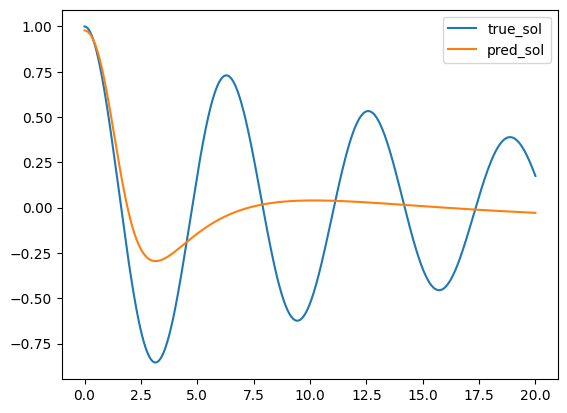

In [16]:
import matplotlib.pyplot as plt
model = jax.vmap(lambda t: net(params, t))

plt.plot(t, jnp.real(sol(t)), label='true_sol')
plt.plot(t, model(t), label='pred_sol')
plt.legend()